## IMPORTS

In [7]:
from google.colab import drive 
drive.mount('/content/drive')

%cd "/root/ray_results/"
!ls -l
#!rm -rf PPO_continuousDoubleAuction-v0_*
!ls -l
!pwd

%cd "/content/drive/MyDrive/Colab\ Notebooks/gym-continuousDoubleAuction-master/"
!ls -l

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/root/ray_results/'
/content/drive/MyDrive/Colab Notebooks/gym-continuousDoubleAuction-master
total 39
-rw------- 1 root root   394 Jul 22  2020 CONTRIBUTING.md
drwx------ 2 root root  4096 Mar 19 13:36 gym_continuousDoubleAuction
drwx------ 2 root root  4096 Mar 19 13:36 gym_continuousDoubleAuction.egg-info
-rw------- 1 root root  1072 Jul 22  2020 LICENSE
drwx------ 2 root root  4096 Mar 19 13:36 pic
-rw------- 1 root root 18145 Jul 22  2020 README.md
-rw------- 1 root root  1592 Jul 22  2020 requirements.txt
-rw------- 1 root root   595 Jul 22  2020 setup.py
drwx------ 2 root root  4096 Mar 19 13:43 src
total 39
-rw------- 1 root root   394 Jul 22  2020 CONTRIBUTING.md
drwx------ 2 root root  4096 Mar 19 13:36 gym_continuousDoubleAuction
drwx------ 2 root root  4096 Mar 19 13:36 gym_continuousDoubleAuction.egg-info
-rw

In [8]:
cd /content/drive/MyDrive/Colab\ Notebooks/gym-continuousDoubleAuction-master/


/content/drive/MyDrive/Colab Notebooks/gym-continuousDoubleAuction-master


In [9]:
cd gym-continuousDoubleAuction-master/


[Errno 2] No such file or directory: 'gym-continuousDoubleAuction-master/'
/content/drive/MyDrive/Colab Notebooks/gym-continuousDoubleAuction-master


In [10]:
ls

CONTRIBUTING.md                        LICENSE    requirements.txt
gym_continuousDoubleAuction/           pic/       setup.py
gym_continuousDoubleAuction.egg-info/  README.md  src/


In [11]:
!pip install -r requirements.txt

     |████████████████████████████████| 112kB 11.0MB/s 
     |████████████████████████████████| 1.2MB 16.9MB/s 
     |████████████████████████████████| 112kB 37.3MB/s 
     |████████████████████████████████| 163kB 37.3MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 829kB 36.0MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 2.7MB 38.5MB/s 
     |████████████████████████████████| 1.6MB 35.8MB/s 
Obtaining gym_continuousDoubleAuction from git+https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git@122434fcbf2e77fe06030edde22067bc8b6fc4f4#egg=gym_continuousDoubleAuction (from -r requirements.txt (line 27))
  Skipping because already up-to-date.
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 296kB 33.8MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |███████████████

In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

from collections import defaultdict
from typing import Dict

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.policy import Policy
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.env import BaseEnv
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies, create_train_policy_list
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import storage
from gym_continuousDoubleAuction.train.callbk.callbk_handler import store_eps_hist_data
from gym_continuousDoubleAuction.train.logger.log_handler import create_dir, log_g_store, load_g_store
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_storage, plot_LOB_subplot, plot_sum_ord_imb, plot_mid_prices
from gym_continuousDoubleAuction.train.helper.helper import ord_imb, sum_ord_imb, mid_price

tf = try_import_tf()

## Env_args

In [13]:
# CDA_env args
num_agents = 9
num_trained_agent = 3 # 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 4096 # per episode, -1 in arg. (~7.2s/1000steps/iter)
is_render = False 

# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
#num_cpus = 0.25                                
num_gpus = 0.75 #0                       
num_cpus_per_worker = 0.25                                
num_gpus_per_worker = 0
num_workers = 2
num_envs_per_worker = 4
batch_mode = "complete_episodes" 
rollout_fragment_length = 128
train_batch_size = max_step
sgd_minibatch_size = 256
num_iters = 1

log_base_dir = "/content/drive/MyDrive/Colab\ Notebooks/gym-continuousDoubleAuction-master/results/"
log_dir = log_base_dir + "ray_results/"

# Chkpt & restore
local_dir = log_base_dir + "chkpt/"
chkpt_freq = 10
chkpt = 320
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = True # True / False

# log & load 
log_g_store_dir = log_base_dir + "log_g_store/"
create_dir(log_base_dir)    
create_dir(log_g_store_dir)    

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

# Global storage, a ray actor that run on it's own process & it needs to be declared after ray.init().
g_store = storage.options(name="g_store", detached=True).remote(num_agents)

2021-03-19 14:12:56,176	INFO resource_spec.py:212 -- Starting Ray with 7.32 GiB memory available for workers and up to 3.68 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


train_policy_list =  ['policy_0', 'policy_1', 'policy_2']
Folder creation failed or folder already exists: /content/drive/MyDrive/Colab\ Notebooks/gym-continuousDoubleAuction-master/results/
Folder created: /content/drive/MyDrive/Colab\ Notebooks/gym-continuousDoubleAuction-master/results/log_g_store/


2021-03-19 14:12:56,778	INFO services.py:1170 -- View the Ray dashboard at 127.0.0.1:8265


In [14]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

def policy_mapper(agent_id):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:            
            return "policy_{}".format(i)

policies: {'policy_0': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_1': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_2': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_3': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_4': (<class 'gym_continuousDoubleAuction.train.policy.policy_handler.make_RandomPolicy.<locals>.RandomPolicy'>, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0

In [15]:
class MyCallbacks(DefaultCallbacks):
    def on_episode_start(self, worker: RolloutWorker, base_env: BaseEnv,
                         policies: Dict[str, Policy],
                         episode: MultiAgentEpisode, **kwargs):
        """
        info["episode"] is a MultiAgentEpisode object.

        user_data dicts at 100000 items max, will auto replace old with new item at 1st index.
        hist_data dicts at 100 items max, will auto replace old with new item at 1st index.
        """
        #print("on_episode_start {}, _agent_to_policy {}".format(episode.episode_id, episode._agent_to_policy))

        prefix = "agt_"
        for i in range(num_agents):
            episode.user_data[prefix + str(i) + "_obs"] = []
            episode.user_data[prefix + str(i) + "_act"] = []
            episode.user_data[prefix + str(i) + "_reward"] = []
            episode.user_data[prefix + str(i) + "_NAV"] = []
            episode.user_data[prefix + str(i) + "_num_trades"] = []

            episode.hist_data[prefix + str(i) + "_reward"] = []
            episode.hist_data[prefix + str(i) + "_NAV"] = []
            episode.hist_data[prefix + str(i) + "_num_trades"] = []

    def on_episode_step(self, worker: RolloutWorker, base_env: BaseEnv,
                        episode: MultiAgentEpisode, **kwargs):
        """
        pole_angle = abs(episode.last_observation_for()[2])
        raw_angle = abs(episode.last_raw_obs_for()[2])
        assert pole_angle == raw_angle
        episode.user_data["pole_angles"].append(pole_angle)
        """

        prefix = "agt_"
        for i in range(num_agents):
            obs = episode.last_raw_obs_for(i)
            #obs = episode.last_observation_for(i)
            act = episode.last_action_for(i)
            reward = episode.last_info_for(i).get("reward")
            NAV = episode.last_info_for(i).get("NAV")
            NAV = None if NAV is None else float(NAV)
            num_trades = episode.last_info_for(i).get("num_trades")
        
            if reward is None:      # goto next agent.
                continue

            episode.user_data[prefix + str(i) + "_obs"].append(obs)    
            episode.user_data[prefix + str(i) + "_act"].append(act)    
            episode.user_data[prefix + str(i) + "_reward"].append(reward)    
            episode.user_data[prefix + str(i) + "_NAV"].append(NAV)    
            episode.user_data[prefix + str(i) + "_num_trades"].append(num_trades)          

    def on_episode_end(self, worker: RolloutWorker, base_env: BaseEnv,
                       policies: Dict[str, Policy], episode: MultiAgentEpisode,
                       **kwargs):
        #print("on_episode_end {}, episode.agent_rewards {}".format(episode.episode_id, episode.agent_rewards))
        """
        arg: {"env": .., "episode": ...}
        """

        g_store = ray.util.get_actor("g_store")
        prefix = "agt_"
        for agt_id in range(num_agents):
            obs_key = prefix + str(agt_id) + "_obs"
            act_key = prefix + str(agt_id) + "_act"
            reward_key = prefix + str(agt_id) + "_reward"
            NAV_key = prefix + str(agt_id) + "_NAV"
            num_trades_key = prefix + str(agt_id) + "_num_trades"      

            # store into episode.hist_data
            store_eps_hist_data(episode, reward_key)
            store_eps_hist_data(episode, NAV_key)
            store_eps_hist_data(episode, num_trades_key)

            # store step data
            obs = episode.user_data[obs_key]
            act = episode.user_data[act_key]
            reward = episode.user_data[reward_key]
            NAV = episode.user_data[NAV_key]
            num_trades = episode.user_data[num_trades_key]
            ray.get(g_store.store_agt_step.remote(agt_id, obs, act, reward, NAV, num_trades))       
        
            # Store episode data.   
            eps_reward = np.sum(reward)
            eps_NAV = np.sum(NAV)
            eps_num_trades = np.sum(num_trades)
            ray.get(g_store.store_agt_eps.remote(agt_id, eps_reward, eps_NAV, eps_num_trades))

        ray.get(g_store.inc_eps_counter.remote())  

    def on_sample_end(self, worker: RolloutWorker, samples: SampleBatch,
                      **kwargs):
        """
        arg: {"samples": .., "worker": ...}

        Notes:
            https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py        
        """
        #print("on_sample_end returned sample batch of size {}".format(samples.count))

        """
        MultiAgentBatch_obj = info["samples"]
        MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
        MultiAgentBatch_count = MultiAgentBatch_obj.count

        access_sample_batches(MultiAgentBatch_policy_batches)
        print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
        print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object
        """

    def on_train_result(self, trainer, result: dict, **kwargs):
        """
        info["trainer"] is the trainer object.

        info["result"] contains a bunch of info such as episodic rewards for 
        each policy in info["result"][hist_stats] dictionary.
        """
        #print("trainer.train() result: {} -> {} episodes".format(trainer, result["episodes_this_iter"]))
        # you can mutate the result dict to add new fields to return
        result["callback_ok"] = True
        #print("on_train_result result", result)
    
        train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
        max_reward_ind = get_max_reward_ind(result, train_policies_name)
        max_reward_policy_name = train_policies_name[max_reward_ind]
        cp_weight(trainer, train_policies_name, max_reward_policy_name)    

        g_store = ray.util.get_actor("g_store")      
        prefix = "policy_policy_"
        suffix = "_reward"
        hist_stats = result["hist_stats"]
        eps_this_iter = result["episodes_this_iter"]
        for agt_id in range(num_agents):
            key = prefix + str(agt_id) + suffix
            for i in range(eps_this_iter):
                ray.get(g_store.store_agt_train.remote(agt_id, hist_stats[key][i]))

        #print("on_train_result info['result'] {}".format(info["result"]))     

    def on_postprocess_trajectory(
            self, worker: RolloutWorker, episode: MultiAgentEpisode,
            agent_id: str, policy_id: str, policies: Dict[str, Policy],
            postprocessed_batch: SampleBatch,
            original_batches: Dict[str, SampleBatch], **kwargs):
        #print("postprocessed {}, {}, {}, {} steps".format(episode, agent_id, policy_id, postprocessed_batch.count))
        """
        if "num_batches" not in episode.custom_metrics:
            episode.custom_metrics["num_batches"] = 0
        episode.custom_metrics["num_batches"] += 1        

        arg: {"agent_id": ..., "episode": ...,
              "pre_batch": (before processing),
              "post_batch": (after processing),
              "all_pre_batches": (other agent ids)}

        # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
        Dictionaries in a sample_obj, k:
            t
            eps_id
            agent_index
            obs
            actions
            rewards
            prev_actions
            prev_rewards
            dones
            infos
            new_obs
            action_prob
            action_logp
            vf_preds
            behaviour_logits
            unroll_id       
        """

        """
        policy_obj = info["pre_batch"][0]
        sample_obj = info["pre_batch"][1]    
        agt_id = info["agent_id"]
        eps_id = info["episode"].episode_id
        """

In [16]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": train_policy_list,
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    #config["num_cpus"] = num_cpus     # trainer, applicable only when using tune.
    config["num_gpus"] = num_gpus     # trainer
    config["num_cpus_per_worker"] = num_cpus_per_worker                                
    config["num_gpus_per_worker"] = num_gpus_per_worker                      
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = batch_mode       # "complete_episodes" / "truncate_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["rollout_fragment_length"] = rollout_fragment_length # replaced "sample_batch_size",
    config["sgd_minibatch_size"] = sgd_minibatch_size 
    config["log_level"] = "WARN" # WARN/INFO/DEBUG 
    config["callbacks"] = MyCallbacks
    config["output"] = log_dir

    return config

## Train

In [17]:
def go_train(config):    
    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    
 

    g_store = ray.util.get_actor("g_store")          
    result = None
    for i in range(num_iters):
        result = trainer.train()       
        print(pretty_print(result)) # includes result["custom_metrics"]
        print("training loop = {} of {}".format(i + 1, num_iters))            
        print("eps sampled so far {}".format(ray.get(g_store.get_eps_counter.remote())))

        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)

    print("result['experiment_id']", result["experiment_id"])
    
    return result["experiment_id"]
    
# run everything
experiment_id = go_train(get_config())

2021-03-19 14:12:58,347	INFO trainer.py:421 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2021-03-19 14:12:58,535	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=369) /usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=369)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=455) /usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=455)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


2021-03-19 14:13:52,419	INFO trainable.py:180 -- _setup took 53.893 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-03-19 14:13:52,420	INFO trainable.py:217 -- Getting current IP.
2021-03-19 14:13:52,424	WARNING util.py:37 -- Install gputil for GPU system monitoring.


(pid=369) 2021-03-19 14:14:25,688	WARNING sampler.py:408 -- More than 5004 observations for 557 env steps are buffered in the sampler. If this is more than you expected, check that that you set a horizon on your environment correctly and that it terminates at some point. Note: In multi-agent environments, `rollout_fragment_length` sets the batch size based on environment steps, not the steps of individual agents, which can result in unexpectedly large batches. Also, you may be in evaluation waiting for your Env to terminate (batch_mode=`complete_episodes`). Make sure it does at some point.
callback_ok: true
custom_metrics:
  agt_0_NAV_max: 1040141.0109863281
  agt_0_NAV_mean: 1014675.5815429688
  agt_0_NAV_min: 989210.1520996094
  agt_0_num_trades_max: 793.701904296875
  agt_0_num_trades_mean: 793.523681640625
  agt_0_num_trades_min: 793.345458984375
  agt_0_reward_max: -297764.25806206814
  agt_0_reward_mean: -787945.922222739
  agt_0_reward_min: -1278127.5863834098
  agt_1_NAV_max: 1

## Plots

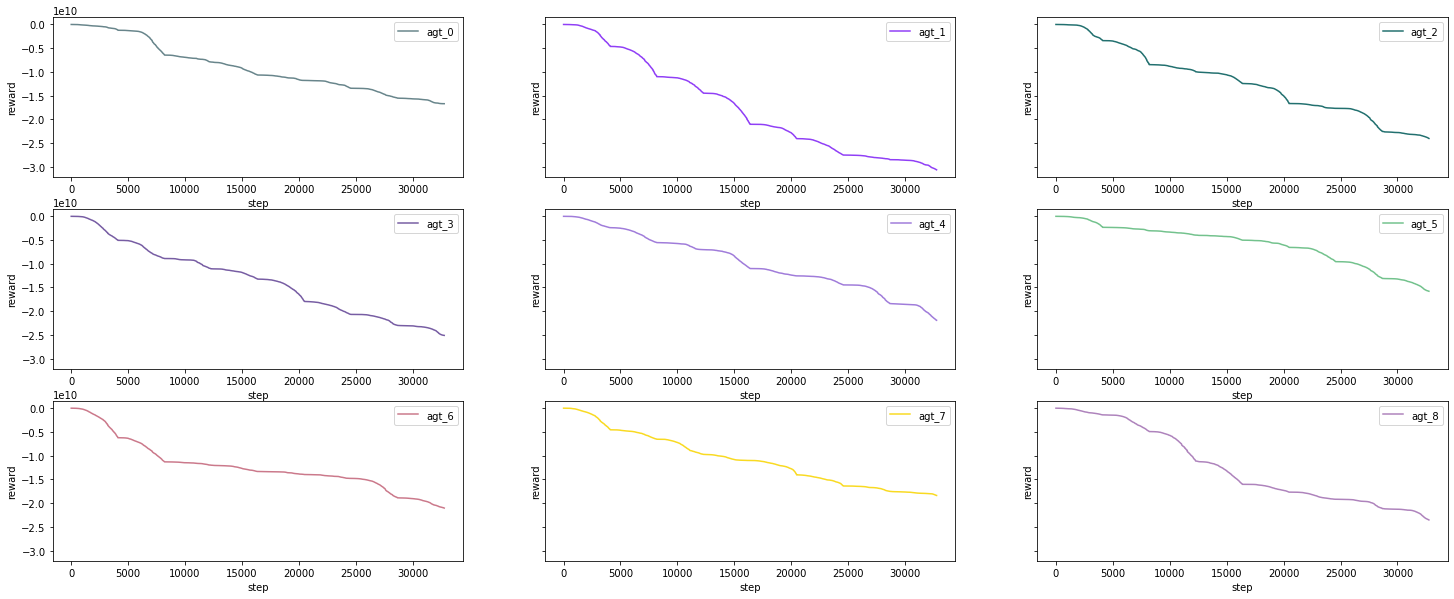

In [18]:
plot_storage(num_agents, init_cash)

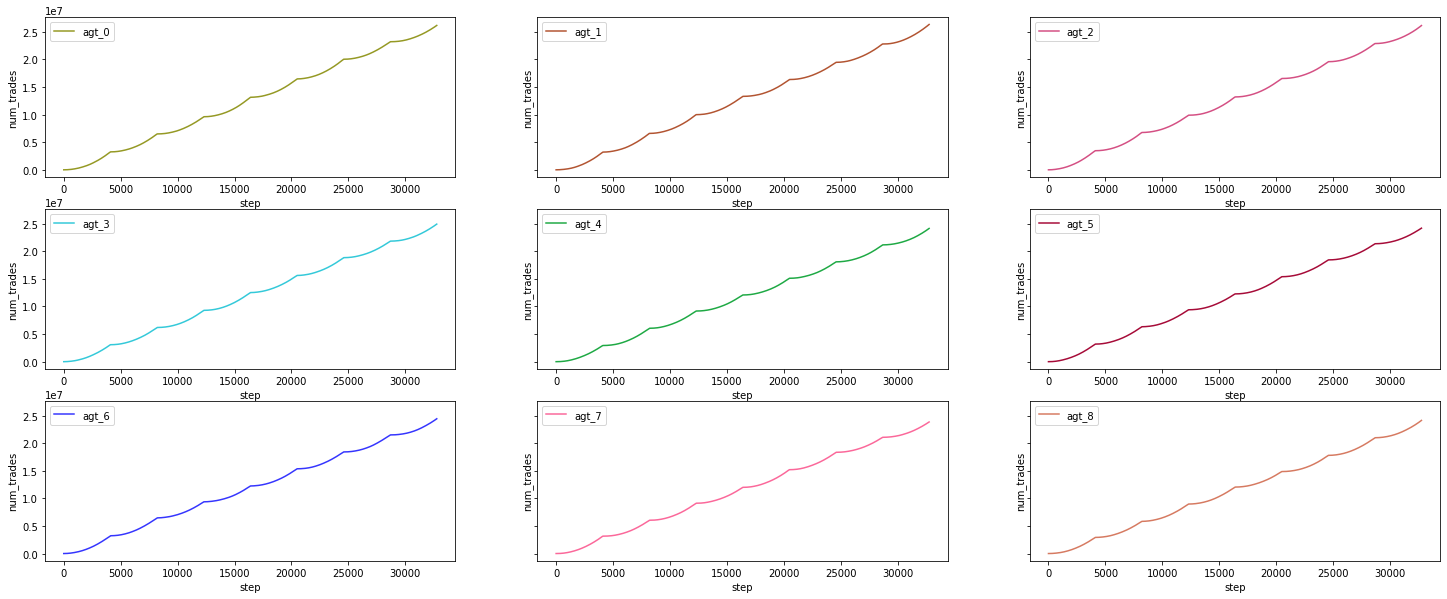

In [19]:
plot_storage(num_agents, init_cash, "step", "num_trades")